# 1. 보조지표로 만드는 매매전략 RSI

## (1) ta 설치
- ta는 금융 시계열 데이터로 RSI 등의 기술적 지표(Technical Indicator)를 생성하는 Python library이다.
- 커뮤니티 및 관련 정보는 아래 사이트에서 확인 가능하다.
    - Homepage : https://technical-analysis-library-in-python.readthedocs.io/en/latest/#
    - Github : https://github.com/bukosabino/ta

In [1]:
# terminal 등의 방법으로도 설치 가능

# ! pip install ta

## (2) 데이터 가져오기
- pandas를 이용하여 데이터를 불러오고 정제한다.


In [2]:
# pandas를 이용해 삼성전자 주가 데이터 불러오기

import pandas as pd
import numpy as np

data_samsung = pd.read_parquet('../chapter4/005930.parquet').set_index('timestamp')
data_samsung = data_samsung[data_samsung.volume > 0] # 거래량이 없는(e.g. 토요일) 날짜 제외
data_samsung

,ticker,open,high,low,close,volume
timestamp,,,,,,
20100104,005930,16060.0,16180.0,16000.0,16180.0,11963550.0
20100105,005930,16520.0,16580.0,16300.0,16440.0,27960950.0
20100106,005930,16580.0,16820.0,16520.0,16820.0,22987750.0
20100107,005930,16820.0,16820.0,16260.0,16260.0,22161850.0
20100108,005930,16400.0,16420.0,16120.0,16420.0,14789900.0
...,...,...,...,...,...,...
20240423,005930,76400.0,76800.0,75500.0,75500.0,18717699.0
20240424,005930,77500.0,78800.0,77200.0,78600.0,22166150.0
20240425,005930,77300.0,77500.0,76300.0,76300.0,15549134.0


In [3]:
# 데이터 분리

t1, t2, t3 = '2010', '2020', '2024'
df_train = data_samsung.loc[(data_samsung.index >= t1) & (data_samsung.index < t2)].dropna(axis=0)  
df_test = data_samsung.loc[(data_samsung.index >= t2) & (data_samsung.index < t3)].iloc[:-1]   

## (3) RSI 생성
- 시계열 데이터의 종가(Close) 값들과 ta library의 momentum.rsi 함수를 사용하여 RSI를 생성해본다.
    - Homepage : https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html#ta.momentum.rsi
- RSI를 계산하는 기간은 9일, 14일, 15일 등 목표에 따라 다양하게 조절할 수 있다.

In [4]:
# ta를 이용하여 rsi 생성
import ta

df_train['RSI'] = ta.momentum.rsi(df_train['close'], window=14)
df_train

,ticker,open,high,low,close,volume,RSI
timestamp,,,,,,,
20100104,005930,16060.0,16180.0,16000.0,16180.0,11963550.0,NaN
20100105,005930,16520.0,16580.0,16300.0,16440.0,27960950.0,NaN
20100106,005930,16580.0,16820.0,16520.0,16820.0,22987750.0,NaN
20100107,005930,16820.0,16820.0,16260.0,16260.0,22161850.0,NaN
20100108,005930,16400.0,16420.0,16120.0,16420.0,14789900.0,NaN
...,...,...,...,...,...,...,...
20191223,005930,56100.0,56400.0,55100.0,55500.0,9839252.0,65.680174
20191224,005930,55600.0,55700.0,54800.0,55000.0,11868463.0,61.669482
20191226,005930,54700.0,55400.0,54400.0,55400.0,9645034.0,63.585225


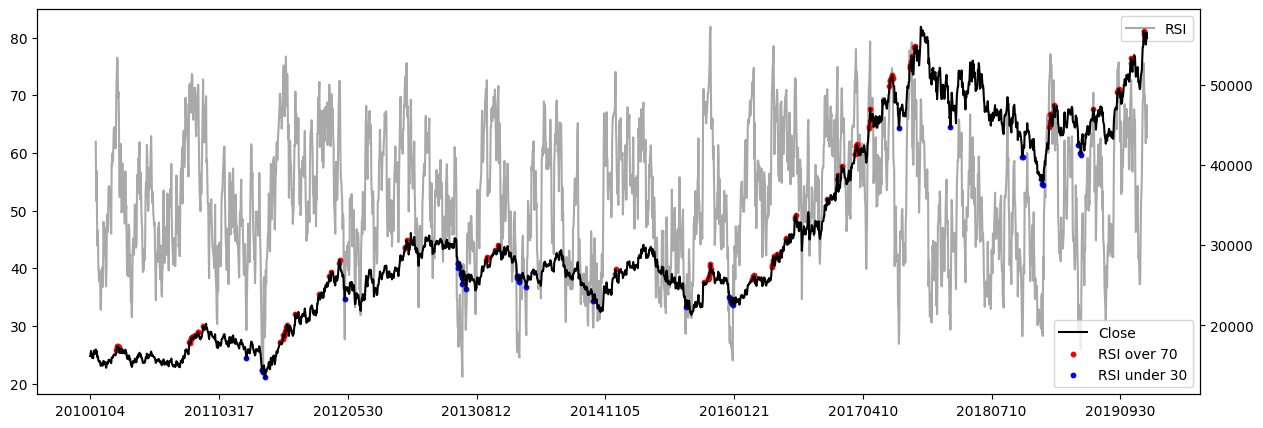

In [5]:
# 주가 및 생성된 rsi 값 plotting

import matplotlib.pyplot as plt

rsi_u, rsi_l = 70, 30

fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(df_train['RSI'], color='darkgrey', label='RSI')
axs.set_xticks(df_train.index[::300])
axs.legend(loc="upper right")
axs_rsi0 = axs.twinx()
axs_rsi0.plot(df_train['close'], color='black', label='Close')
axs_rsi0.scatter(df_train.loc[df_train['RSI'] > rsi_u].index, df_train.loc[df_train['RSI'] > rsi_u, 'close'], color='red', s=10, label='RSI over 70')
axs_rsi0.scatter(df_train.loc[df_train['RSI'] < rsi_l].index, df_train.loc[df_train['RSI'] < rsi_l, 'close'], color='blue', s=10, label='RSI under 30')
axs_rsi0.legend(loc="lower right")


## (4) 제안 매매 알고리즘
- rsi를 기준으로 과매도 시 매수, 과매수 시 매도를 진행하는 알고리즘을 구현한다.
- rsi의 window 크기나 과매도 및 과매수 기준은 각자의 기준에 따라 다양하게 정할 수 있다. 본 실습에서는, train 기간 동안의 데이터로 가장 우수한 성능을 갖는 window 크기 및 과매도/과매수 기준을 찾고, test 기간의 데이터를 통해 성능을 확인한다.


### 1) train: 2010년~2019년까지의 삼성전자 데이터에 대해 가장 우수한 성능을 갖는 window 크기(ws) 및 과매수/과매도 기준(rsi_u, rsi_l)을 찾는다

In [6]:
### 모델 특성 조합 정의

import itertools

rsi_ws_list = [7, 9, 14, 15, 21, 28]
rsi_u_list = [70, 75, 80, 85, 90, 95]
rsi_l_list = [5, 10, 15, 20, 25, 30,]

params = list(itertools.product(*[rsi_ws_list, rsi_u_list, rsi_l_list]))
params

[(7, 70, 5),
 (7, 70, 10),
 (7, 70, 15),
 (7, 70, 20),
 (7, 70, 25),
 (7, 70, 30),
 (7, 75, 5),
 (7, 75, 10),
 (7, 75, 15),
 (7, 75, 20),
 (7, 75, 25),
 (7, 75, 30),
 (7, 80, 5),
 (7, 80, 10),
 (7, 80, 15),
 (7, 80, 20),
 (7, 80, 25),
 (7, 80, 30),
 (7, 85, 5),
 (7, 85, 10),
 (7, 85, 15),
 (7, 85, 20),
 (7, 85, 25),
 (7, 85, 30),
 (7, 90, 5),
 (7, 90, 10),
 (7, 90, 15),
 (7, 90, 20),
 (7, 90, 25),
 (7, 90, 30),
 (7, 95, 5),
 (7, 95, 10),
 (7, 95, 15),
 (7, 95, 20),
 (7, 95, 25),
 (7, 95, 30),
 (9, 70, 5),
 (9, 70, 10),
 (9, 70, 15),
 (9, 70, 20),
 (9, 70, 25),
 (9, 70, 30),
 (9, 75, 5),
 (9, 75, 10),
 (9, 75, 15),
 (9, 75, 20),
 (9, 75, 25),
 (9, 75, 30),
 (9, 80, 5),
 (9, 80, 10),
 (9, 80, 15),
 (9, 80, 20),
 (9, 80, 25),
 (9, 80, 30),
 (9, 85, 5),
 (9, 85, 10),
 (9, 85, 15),
 (9, 85, 20),
 (9, 85, 25),
 (9, 85, 30),
 (9, 90, 5),
 (9, 90, 10),
 (9, 90, 15),
 (9, 90, 20),
 (9, 90, 25),
 (9, 90, 30),
 (9, 95, 5),
 (9, 95, 10),
 (9, 95, 15),
 (9, 95, 20),
 (9, 95, 25),
 (9, 95, 30),
 (14

In [7]:
# 

for ws in rsi_ws_list:
    df_train[f'RSI_{ws}'] = ta.momentum.rsi(df_train['close'], window=ws).shift(1) # 전날의 rsi 값
    
train_results = pd.DataFrame(columns=['ws', 'rsi_u', 'rsi_l', 'return', 'num_of_trades'])

for ws, rsi_u, rsi_l in params:

    ################ 백테스팅 파라미터 #############
    holding_cash = 1_000_000 # 보유 현금
    position = 0 # 현재 보유 포지션
    avg_price = 0 # 평단가
    daily_total_value = [] #일별 총 포트폴리오 가치
    slippage = 0.0025 # 슬리피지 
    ################ 백테스팅 파라미터 #############

    
    n_trades = 0

    # 한 row 씩 루프
    for idx, data in df_train.iterrows():

        if (np.isnan(data[f'RSI_{ws}'])):
            # 이전 rsi 값이 계산된 경우에만 알고리즘 매매 진행
            continue

        daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가


        # 매수: 과매도 상황(즉, RSI가 rsi_l 이하일 때)
        if (position == 0) and (data[f'RSI_{ws}'] < rsi_l): 
            # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산
            position = int(holding_cash / data['close'])
            holding_cash -= position * data['close']
            avg_price = data['close']
            n_trades += 1 # 매수 시점 개수 카운팅을 통해 전체 거래 횟수를 파악

        # 매도: 과매수 상황(즉, RSi가 rsi_u 이상일 때)
        elif (position > 0) and (data[f'RSI_{ws}'] > rsi_u):   
            holding_cash += (position * data['close']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
            position = 0
            avg_price = 0

        daily_total_value[-1]+= holding_cash+ position* data['close'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산

    train_results.loc[len(train_results)] = [ws, rsi_u, rsi_l, daily_total_value[-1] / 1_000_000, n_trades]

In [8]:
# 충분히 거래가 되는(즉, train 기간 동안 거래 횟수가 5 초과인) 조합 중, 가장 성능이 좋은 조합을 찾는다.

train_results.loc[train_results.num_of_trades > 5].sort_values(by='return', ascending=False).iloc[:10]

,ws,rsi_u,rsi_l,return,num_of_trades
59,9.0,85.0,30.0,3.751815,6.0
119,15.0,75.0,30.0,3.210511,6.0
113,15.0,70.0,30.0,3.142941,9.0
22,7.0,85.0,25.0,3.007216,10.0
23,7.0,85.0,30.0,2.935554,11.0
10,7.0,75.0,25.0,2.932362,24.0
53,9.0,80.0,30.0,2.904054,11.0
16,7.0,80.0,25.0,2.818507,19.0
4,7.0,70.0,25.0,2.743201,26.0
15,7.0,80.0,20.0,2.566757,13.0


In [9]:
# 최적의 조합
ws, rsi_u, rsi_l, _, _ = train_results.loc[train_results.num_of_trades > 5].sort_values(by='return', ascending=False).iloc[0]

### 2) test: train 기간의 데이터를 통해 구한 전략(ws, rsi_u, rsi_l)으로 test 기간에서의 성능을 파악한다.

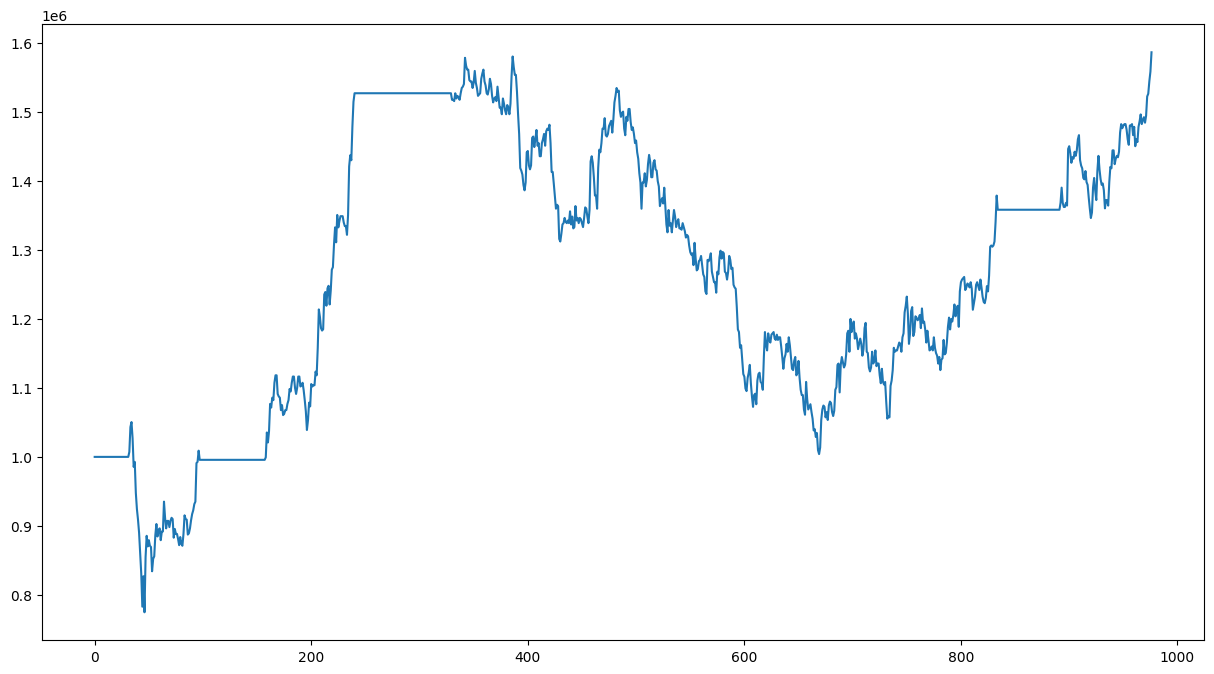

In [10]:
# test 기간을 통해 매매 전략 성능 파악 

df_test[f'RSI_{ws}'] = ta.momentum.rsi(df_test['close'], window=ws).shift(1)
    
################ 백테스팅 파라미터 #############
holding_cash = 1_000_000 # 보유 현금
position = 0 # 현재 보유 포지션
avg_price = 0 # 평단가
daily_total_value = [] #일별 총 포트폴리오 가치
slippage = 0.0025 # 슬리피지 
################ 백테스팅 파라미터 #############


n_trades = 0

# 한 row 씩 루프
for idx, data in df_test.reset_index().iterrows():

    if (np.isnan(data[f'RSI_{ws}'])):
        # 이전 rsi 값이 계산된 경우에만 알고리즘 매매 진행
        continue

    daily_total_value.append(0) # 일별 포트폴리오 가치 List에 새로운 값 추가


    # 매수: 과매도 상황(즉, RSI가 rsi_l 이하일 때)
    if (position == 0) and (data[f'RSI_{ws}'] < rsi_l): 
        # 주식 매수 시의 현금 감소, 포지션 증가, 평단가 변화 계산
        position = int(holding_cash / data['close'])
        holding_cash -= position * data['close']
        avg_price = data['close']
        n_trades += 1 # 매수 시점 개수 카운팅을 통해 전체 거래 횟수를 파악

    # 매도: 과매수 상황(즉, RSi가 rsi_u 이상일 때)
    elif (position > 0) and (data[f'RSI_{ws}'] > rsi_u):   
        holding_cash += (position * data['close']) * (1-slippage) # 포지션 매도 시 세금/수수료를 제한 값만 현금으로 돌아옴
        position = 0
        avg_price = 0

    daily_total_value[-1]+= holding_cash+ position* data['close'] # 당일 종료 시점에서 보유 현금 + 주식 평가가치로 총 포트폴리오 가치 계산

plt.figure(figsize=(15,8))
plt.plot(daily_total_value)

### (3) 전략 성과 측정

총 수익률: 58.59%
------------------------------------------------
총 백테스팅 기간: 3.91년
연 수익률: 12.52%
------------------------------------------------
일 수익률: 0.05%, 일 변동성: 0.01%
Sharpe ratio: 0.55
------------------------------------------------
MDD: -36.44%


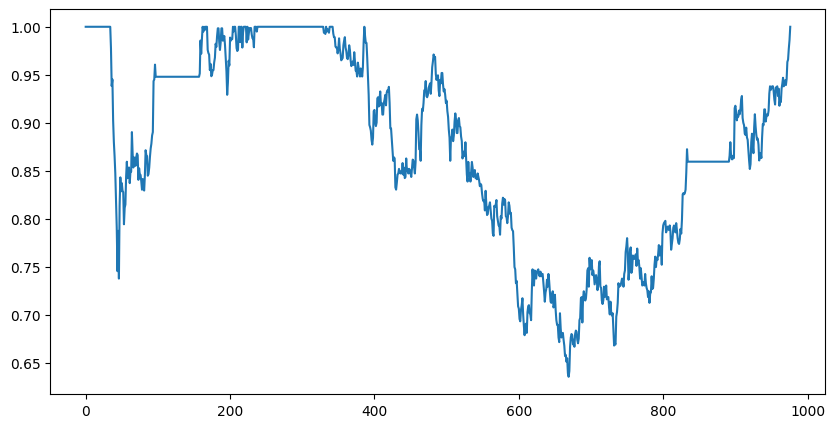

------------------------------------------------


In [11]:
# 전략 총 수익률 계산
total_return_pct = daily_total_value[-1]/daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(daily_total_value))
daily_std = pd.DataFrame(daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')


### 4) 벤치마크와의 비교

총 수익률: 41.30%
------------------------------------------------
총 백테스팅 기간: 3.94년
연 수익률: 9.16%
------------------------------------------------
일 수익률: 0.04%, 일 변동성: 0.02%
Sharpe ratio: 0.35
------------------------------------------------
MDD: -42.20%


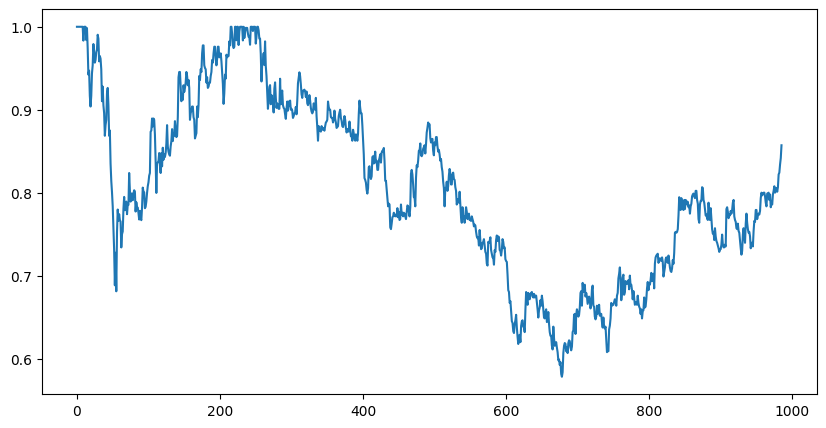

------------------------------------------------


In [12]:
# 삼성전자 Buy & Hold의 수익률 계산

bm_daily_total_value = df_test['close'].values/df_test['close'].values[0]

# 전략 총 수익률 계산
total_return_pct = bm_daily_total_value[-1]/bm_daily_total_value[0]
print('총 수익률: {:.2f}%'.format((total_return_pct-1)*100))

print('------------------------------------------------')

# 1년을 250일로 가정, 연 복리 수익률 계산
total_years = len(bm_daily_total_value)/250
print('총 백테스팅 기간: {:.2f}년'.format(total_years))

import math
annaul_return = math.pow(total_return_pct,1/total_years)

print('연 수익률: {:.2f}%'.format((annaul_return-1)*100))

print('------------------------------------------------')

# Sharpe Ratio
daily_return = math.pow(total_return_pct,1/len(bm_daily_total_value))
daily_std = pd.DataFrame(bm_daily_total_value).pct_change().std()[0]

print('일 수익률: {:.2f}%, 일 변동성: {:.2f}%'.format((daily_return-1)*100,daily_std))
print('Sharpe ratio: {:.2f}'.format(((daily_return-1)/daily_std)*np.sqrt(250)))

print('------------------------------------------------')

# MDD 계산
tv = pd.DataFrame(bm_daily_total_value)
dd = tv/tv.cummax()
print('MDD: {:.2f}%'.format((dd.min()-1)[0]*100))


plt.figure(figsize=(10,5))
plt.plot(dd)
plt.show()

print('------------------------------------------------')
